# 9.1 Camera calibration

In previous notebooks we learnt how world points are transformed into image pixels, using Pinhole camera model. In this transformation several variables are involved, these variables are either extrinsic (external) or intrinsic (internal). The interesting part of **intrinsic variables** is that they **are constant** for the same camera, **extrinsic variables** deppends on the position and orientation of the camera.

$$\lambda \begin{bmatrix} x' \\ y'\\ 1 \end{bmatrix} = \underbrace{\begin{bmatrix} f k_x & 0 & x'_0  \\ 0 & f k_y & y'_0 \\ 0 & 0 & 1 \end{bmatrix}}_{\text{intrinsic}} \underbrace{\begin{bmatrix} \bf{R} & \bf{t}\end{bmatrix}}_{\text{extrinsic}} \begin{bmatrix} X_W \\ Y_W\\ Z_W \\ 1 \end{bmatrix} \qquad \bf{\lambda \tilde{m}' = K \left[ R\ t \right] \tilde{M}_W}$$

**Camera calibration is the process of estimating intrinsic and/or extrinsic parameters**. Intrinsic parameters deal with the camera's internal characteristics, such as, its focal length ($f$), skew ($k_x, k_y$), and image center ($x_0, y_0$). Extrinsic parameters describe its position ($t$) and orientation ($R$) in the world. Knowing intrinsic parameters is an essential first step for 3D computer vision..

In this notebook, we are going to learn

- Lens distortion
- a general procedure for calibration
- Direct linear transformation (DLT) calibration method
- Zhang's method

## Problem contex - Removing the lens distortion

All cameras have radial distorition, caused by its lens. Sometimes, this distortion is desired and sometimes is not. A typical example of high radial distorition are action cameras.

<img src="./images/intro.jpg" width="400"/>

The distortion degree is given by two intrinsic variables. If someone wants to remove the radial distortion in their images, the camera has to be calibrated. Once those variables are calculated, it is possible to remove the distortion even for a fish-eye camera.

In this notebook we will calcule the distortion degree of your phone's camera, in adition to the other intrinsic variables. Also, we will learn to remove the distortion of our photos.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
import glob

matplotlib.rcParams['figure.figsize'] = (14.0, 10.0)

images_path = './images/'

### Lens distortion

All the cameras (to some degree) distort the image. Obviously, fish-eye cameras and sport cameras have a bigger **radial distortion** (the lens are more convex). But, the point is that even our phone's camera have a little distortion, and we can define it by this formula (*even-order polynomial model*):$\\[10px]$

$$\begin{eqnarray}x'_u = (1 + k_1 r^2 + k_2 r^4 + \ldots)(x'_d-x'_0) \qquad (x'_d, y'_d) \; \; \text{distorted pixels}\\ y'_u = (1 + k_1 r^2 + k_2 r^4 + \ldots)(y'_d-y'_0) \qquad (x'_, y'_u) \; \; \text{undistorted pixels}\end{eqnarray}\\[25px]$$ $$\text{with}\; r^2 = (x'_d-x'_0)^2+(y'_d-y'_0)^2$$

The distortion degree is given by distortion parameters ($k_1,\ k_2, \ldots$), **note that it is not linear**. Also, the smaller the focal length the bigger the lens distortion.
There are two shapes, deppending in the sign of $k_1$:$\\[10px]$

<img src="./images/radial.png" width="600"/>

Although we are not going to study **tangential** distortion, you should know that it exists. This happens when the lens and the camera sensor are not parallel:$\\[10px]$

<img src="./images/tangential.png" width="600"/>

The idea for removing the radial distortion is to **compute (through camera calibration) the distortion parameters**. Then, having $x'_d,\ y'_d,\ x'_0, y'_0$ and $k_1, k_2, \ldots$, we can find a solution for $(x'_u,\ y'_u)$.

The **division model is preferred over the polynomial model** because it requires fewer terms than the poly-nomial model in case of severe distortion. It is also slightly easier to work with:

$$x'_u = x'_0 + \frac{x'_d - x'_0}{1 + k_1 r^2 + k_2 r^4 + \ldots } \qquad y'_u = y'_0 + \frac{y'_d - y'_0}{1 + k_1 r^2 + k_2 r^4 + \ldots }$$

####  **<span style="color:green"><b><i>ASSIGNMENT 1</i></b></span>**

We are using a sport camera with severe radial distortion, intrinsic parameters are provided in camera's documentation. **Compute the undistorted coordinates** for the pixels (0,0), (200,200) and (400,400), knowing that the intrinsic parameters of this camera are:

In [2]:
# Exercise data
k1, k2 = -2.98786806e-06,  4.90775450e-13
x0, y0 = 303, 244

distorted = np.array([[0,200,400],[0,200,400]],dtype=np.float64)

# Define auxiliar matrices
undistorted = np.zeros_like(distorted)
r = np.sqrt((distorted[0,:]-x0)**2 + (distorted[1,:]-y0)**2) 
dr = 1 + k1*(r**2) + k2*(r**4)

# Compute undistorted pixels
undistorted[0,:] = x0 + (distorted[0,:] - x0)/dr
undistorted[1,:] = y0 + (distorted[1,:] - y0)/dr

print(np.round(undistorted,1))

[[-239.   196.   410.8]
 [-192.5  198.3  417.4]]


<font color='blue'>**Expected output:**  </font>

     [[-239.   196.   410.8]
     [-192.5  198.3  417.4]]

### Camera calibration

For camera calibration we can compute the matrix $P_{3\times4}$, which allows to compute the projection $\bf{m}' = [x'\ y']^T$ on the image (in pixels) of any world point $\bf{M} = [X\ Y\ Z]^T$ in space:

$$\lambda\bf{\tilde{m'}}= \begin{bmatrix} \lambda x' \\ \lambda y' \\ \lambda \end{bmatrix} = \bf{P\tilde{M}} = \begin{bmatrix} p_{11} & p_{12} & p_{13} & p_{14} \\ p_{21} & p_{22} & p_{23} & p_{24} \\ p_{31} & p_{32} & p_{33} & p_{34} \end{bmatrix} \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix} \\[30pt]$$

$$x'= \frac{p_{11}X + p_{12}Y + p_{13}Z + p_{14}}{p_{31}X + p_{32}Y + p_{33}Z + p_{34}} \qquad \qquad y'= \frac{p_{21}X + p_{22}Y + p_{23}Z + p_{24}}{p_{31}X + p_{32}Y + p_{33}Z + p_{34}}$$

If we calculate the full transformation matrix, there are some limitations:

- It doesn't tell us (explicitly) what the **camera pose** $(R, t)$ is
- It doesn't tell us (explicitly) about the **camera intrinsic parameters**

What we really compute when we calibrate a camera is:$\\[5pt]$

$$\bf{P = K[R\ t]}\\[10pt]$$

**5 intrinsic parameters** ($f,\ k_x,\ k_y,\ x_0',\ y_0'$):$\\[5pt]$

$$K = \begin{bmatrix} fk_x & 0 & x_0'\\ 0 & fk_y & y_0' \\ 0 & 0 & 1 \end{bmatrix}\\[10pt]$$

**6 extrinsic parameters** ($t_x,\ t_y,\ t_z,\ \text{yaw},\ \text{pitch},\ \text{roll}$):$\\[5pt]$

$$\bf{[R\ t]} = \begin{bmatrix} r_{11} & r_{12} & r_{13} & t_x\\ r_{21} & r_{22} & r_{23} & t_y\\ r_{31} & r_{32} & r_{33} & t_z \end{bmatrix}\\[10pt]$$

Aditionally, **2 radial distortion parameters** ($k_1, \ k_2$):$\\[5pt]$

$$\begin{eqnarray}x'_d = (1 + k_1 r^2 + k_2 r^4)x'_u\\ y'_d = (1 + k_1 r^2 + k_2 r^4)y'_u\end{eqnarray}$$

But, as $R,\ t$ change when the camera moves, **camera calibration** typically refers to computing the matrix $K$, and the distortion parameters $k_1,\ k_2$ (**note that distortion is not a lineal operation**).

### General procedure for calibration

1. **Provide a set of 3D points** (the more the better) $\bf{M_i}$:

For providing the set of 3D points $\bf{M_i}$, a calibration pattern is employed. This pattern should be easily identificable on the image, and the 3D points must not be in a single plane (several planes needed).$\\[8pt]$

<img src="./images/pattern.png" width="600"/>$\\[5pt]$

2. **Provide their projections on the image** $\bf{m_i}$ (in pixels):

For this, we detect the corners of the squares in the pattern (e.g. Harris detector). Then, we set the pairs ($M_i,\ m_i$) based on the 2D ordered list of corners detected (the number of columns and rows of the patterns is known).$\\[8pt]$

<img src="./images/2dPattern.png" width="300"/>$\\[5pt]$

3. **Applying the camera model, estimate the parameters** $\bf{K,\ R,\ t}$ that best solve for the match between corresponding pairs ($M_i,\ m_i$)

This is the more complex step, there are many alternatives. Some are very popular, in this notebook we are going to see two of them:

- Direct Linear Transformation (DLT)
- Zang's method

### DLT calibration method

Computes $\bf{K,\ R,\ t}$ from $\bf{P}$ ($\ge 6$ points needed, as $P$ have $11$ d.o.f):

$$\bf{P} = \begin{bmatrix} p_{11} & p_{12} & p_{13} & p_{14} \\ p_{21} & p_{22} & p_{23} & p_{24} \\ p_{31} & p_{32} & p_{33} & p_{34} \end{bmatrix}$$

- Given $\bf{K,\ R,\ t}$:$\\[5pt]$

$$\bf{P = K\ [R\; t] = [KR\; Kt] = [B\; b]}\\[5pt]$$

- Given $\bf{P = [B\; b] = [KR\; Kt]}$, two steps:

 1. Do RQ-factorization of $\bf{B}$, i.e. $\bf{B = RQ}$. $\;\bf{R}$ is upper triangular (i.e. $\bf{K}$), and $\bf{Q}$ orthogonal (i.e. $\bf{R}$) $\\[10pt]$
    
$$\bf{B}  = \begin{bmatrix} p_{11} & p_{12} & p_{13} \\ p_{21} & p_{22} & p_{23} \\ p_{31} & p_{32} & p_{33} \end{bmatrix} = KR = \underbrace{\begin{bmatrix} k_{11} & k_{12} & k_{13} \\ 0 & k_{22} & k_{23} \\ 0 & 0 & k_{33} \end{bmatrix}}_{\text{intrinsic}}\underbrace{\begin{bmatrix} r_{11} & r_{12} & r_{13} \\ r_{21} & r_{22} & r_{23} \\ r_{31} & r_{32} & r_{33} \end{bmatrix}}_{\text{extrinsic (rotation)}}$$
    
The solution is not unique (different combination of signs), but we can choose the correct one by forcing the diagonal elements of $R (=K)$ to be all positive.

 $\hspace{1cm}$2. Given $\bf{K}$ and $\bf{b}$, since $\bf{b = Kt}$   $\rightarrow$ $\bf{t = K^{-1}b}$ 
 
 $$\bf{b} = \underbrace{\begin{bmatrix} p_{14} \\ p_{24} \\ p_{34} \end{bmatrix}}_{\text{known}} = \bf{Kt} =  \underbrace{\begin{bmatrix} k_{11} & k_{12} & k_{13} \\ 0 & k_{22} & k_{23} \\ 0 & 0 & k_{33} \end{bmatrix}}_{\text{known}} \underbrace{\begin{bmatrix} t_x \\ t_y \\ t_z \end{bmatrix}}_{\text{unknown}}$$
 
 ### Zhang's method
 
This method is more friendly to use, as it doesn't need many knowledge about computer vision and maths.  
 
The **pattern needed is a simple checkboard pattern** (e.g. printed on a paper). It **doesn't need several planes** because this method is **based on 2D homographies** between the template and their images (either the camera of the pattern will the moved).$\\[5pt]$
 
<img src="./images/zhangs.png" width="400"/>$\\[5pt]$
 
**Procedure:**

- **Print the pattern template** and fix it to a rigid planar surface (e.g. a cordboard)$\\[4pt]$

- **Take several images of the pattern** at different poses, either moving the camera or the pattern$\\[4pt]$

- **Detect the corner** of the squares in the images$\\[4pt]$

- Estimate the 5 intrinsic and 6 extrinsic through the **closed form solution** (it's not precise and does not include the radial distortion)$\\[4pt]$

- From the above solution, find a more precise one of $\bf{K,\ R,\ t}$ and $\bf{k_1,\ k_2}$ by **iteratively solving a non-linear system** (with distortion)$\\[4pt]$
 
 
**Step 1**: Close form solution for the linear parameters $\bf{K,\ [R\ t]}:\; 4+6n$ unknowns ($fk_x,\ fk_y$ turns 3 unknowns into 2: $s_x,\ s_y$)

1. Estimate the homography $\bf{H_i}$ for each pair image/plane-pattern$\\[4pt]$

2. Compute the matrix $\bf{K}$ from the set of $\bf{H_i}$$\\[4pt]$

3. Compute $\bf{R,\ t}$ for each plane pattern$\\[4pt]$

But this is not enough, since:

- The computed $\bf{R}$ is not an orthogonal matrix$\\[4pt]$
- No radial distortion considered$\\[4pt]$

**Step 2**: You can **either iterate step 1** and a solution for the lens distortion equations, **or solve for all the parameters** $\bf{K,\ R,\ t}$ and the distortion ($\bf{k_1,\ k_2}$)$\\[4pt]$

$$error = \sum_{i=1}^n\sum_{j=1}^m\; ||bf{m_{ij} - \tilde{m}\ (K,\ R_i, t_i, k_1, k_2, M_j)}||^2$$

**How many images of the pattern do we need?**

If we have $N$ images with $M$ corners each, we have $2NM$ equations. We need to estimate $4$ intrinsic parameters ($\bf{fk_x,\ fk_y,\ x'_0,\ y'_0}$) + $6N$ extrinsic parameters ($\bf{R,\ t}$ for each image).

$$2NM \ge 4 + 6N \Longrightarrow N \ge \frac{2}{M-3}\; \text{and}\; M\gt 3$$

So, we need at least (not the ideal, as more images better solution):

- $N=2$ images with $M=4$ points each  $\hspace{5cm }\color{green}{\text{This is a correct solution, but it will have a bad precision}}$ 

- $N = 1$ images with $M = 5$ points $\rightarrow 2NM = 10,\; 4+6N = 10 \qquad$ $\color{red}{\text{This is not a solution, since points can't be coplanar!}}$ 

####  **<span style="color:green"><b><i>ASSIGNMENT 1</i></b></span>**

Now that you know how camera calibration works, we are going to use **openCV for calibrating our phone camera** (or the examples provided in `/images/calibration` if you don't have one). When we calibrate a camera, the distortion parameters of the camera are also calculated. With them, it is possible to remove the radial distortion of camera images (usually for phone cameras is unnoticeable, but you can use a sport camera if you have one).

OpenCV defines a calibration method [cv2.calibrateCamera](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d), which implements a **variant of Zhang's method**. As explained above, you need a **camera calibration pattern**. In classroom it will be provided, you can as well [print one](https://www.google.com/search?q=camera+calibration+pattern&tbm=isch&ved=2ahUKEwi56NbFsqTpAhWO1uAKHXlVAIAQ2-cCegQIABAA&oq=camera+calibration+pattern&gs_lcp=CgNpbWcQAzICCAAyBggAEAgQHjIGCAAQCBAeMgQIABAYOgQIIxAnOgQIABBDUMIyWMdTYP5UaAJwAHgAgAFbiAGuEJIBAjI4mAEAoAEBqgELZ3dzLXdpei1pbWc&sclient=img&ei=nGG1XrmqPI6tgwf5qoGACA&bih=951&biw=1853&client=ubuntu&hs=qxl&hl=en) for calibrating your camera in home.

Following the steps for calibrating a camera using Zhang's method, **several images of the pattern** from different perspective are needed.

Then, we will have to **detect the corners** (e.g. using Harris corner detector) of all images. Fortunately, openCV defines a optimized method [cv2.findChessboardCorners](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a), which detect automatically the corners of the pattern. Those corners will have to be matched with pixels coordinates without perspective for calculing the homographies. E.g. if we detect the second corner of the third column in the pattern, we will have to match the pixel detected by `cv2.findChessboardCorners` with a multiple of $(1,2)$. The mapping of the corners of pattern's images is the input of `cv2.calibrateCamera`, which returns the intrinsic parameters and the radial and tangential distortion parameters.

**Once we have the intrinsic parameters**, we have to call [cv2.undistort](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga69f2545a8b62a6b0fc2ee060dc30559d), where `undistort` is an approximate **iterative algorithm** that estimates the normalized original point coordinates out of the normalized distorted point coordinates (*normalized* means that the coordinates do not depend on the camera matrix).

**Let's do this step by step:**

First, we are going to define the object points matrix, which is a matrix with size $(\text{corners}\times3)$. This matrix contains the coordinates of the corners in a non-perspective image of the pattern (necessary for obtaining the homographies).

As the corners will be detected using `cv2.findChessboardCorners`, the order of the corners is fixed, and it is like this:

$$[(0,0,0),\ (1,0,0),\ (2,0,0),\ \ldots ,\ (\text{n_rows}, \text{n_cols},0)]$$

Our task is to construct a matrix like this (the third column is mandatory):

<font color='blue'>**Expected output (for a $12\times13$ corners pattern):**  </font>

    [[ 0.  0.  0.]
     [ 1.  0.  0.]
     [ 2.  0.  0.]
     [ 3.  0.  0.]
           .
           .
           .
     [ 8. 12.  0.]
     [ 9. 12.  0.]
     [10. 12.  0.]
     [11. 12.  0.]]

In [3]:
# Pattern corners
corners_r = 7
corners_c = 10

# Prepare object points matrix
objp = np.zeros((corners_r*corners_c,3), dtype= np.float32)
objp[:,:2] = np.mgrid[:corners_r,:corners_c].T.reshape(-1,2)

# Print object points matrix
print(objp)

[[0. 0. 0.]
 [1. 0. 0.]
 [2. 0. 0.]
 [3. 0. 0.]
 [4. 0. 0.]
 [5. 0. 0.]
 [6. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [2. 1. 0.]
 [3. 1. 0.]
 [4. 1. 0.]
 [5. 1. 0.]
 [6. 1. 0.]
 [0. 2. 0.]
 [1. 2. 0.]
 [2. 2. 0.]
 [3. 2. 0.]
 [4. 2. 0.]
 [5. 2. 0.]
 [6. 2. 0.]
 [0. 3. 0.]
 [1. 3. 0.]
 [2. 3. 0.]
 [3. 3. 0.]
 [4. 3. 0.]
 [5. 3. 0.]
 [6. 3. 0.]
 [0. 4. 0.]
 [1. 4. 0.]
 [2. 4. 0.]
 [3. 4. 0.]
 [4. 4. 0.]
 [5. 4. 0.]
 [6. 4. 0.]
 [0. 5. 0.]
 [1. 5. 0.]
 [2. 5. 0.]
 [3. 5. 0.]
 [4. 5. 0.]
 [5. 5. 0.]
 [6. 5. 0.]
 [0. 6. 0.]
 [1. 6. 0.]
 [2. 6. 0.]
 [3. 6. 0.]
 [4. 6. 0.]
 [5. 6. 0.]
 [6. 6. 0.]
 [0. 7. 0.]
 [1. 7. 0.]
 [2. 7. 0.]
 [3. 7. 0.]
 [4. 7. 0.]
 [5. 7. 0.]
 [6. 7. 0.]
 [0. 8. 0.]
 [1. 8. 0.]
 [2. 8. 0.]
 [3. 8. 0.]
 [4. 8. 0.]
 [5. 8. 0.]
 [6. 8. 0.]
 [0. 9. 0.]
 [1. 9. 0.]
 [2. 9. 0.]
 [3. 9. 0.]
 [4. 9. 0.]
 [5. 9. 0.]
 [6. 9. 0.]]


Now, we will **calcule the corners of all the images** (if you use your photos, **don't compress them**, e.g. sharing by whatsapp) contained in `./images/calibration/`  using `findChessboardCorners`, which takes a grayscale image and the rows and columns of corners that our pattern have. It returns a boolean value, which indicates whether the pattern was find in the image or not.

If the corners were found, we will need to **store them in some list**, and add a **copy of the matrix constructed in the previous exercise** for matching them. This is a way of constructing iteratively the mapping that `cv2.calibrateCamera` takes as input.

Also, if you want to check that corners are detected in a correct way, you can draw them in the image using [drawChessboardCorners](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga6a10b0bb120c4907e5eabbcd22319022). Then, show the image.

**In a nutshell:** you need two lists of points

- one containing the coordinates returned by `findChessboardCorners` of each image.
- another containing the **previous exercise matrix**, but repeated the times that the pattern was detected (so both will have the same size).

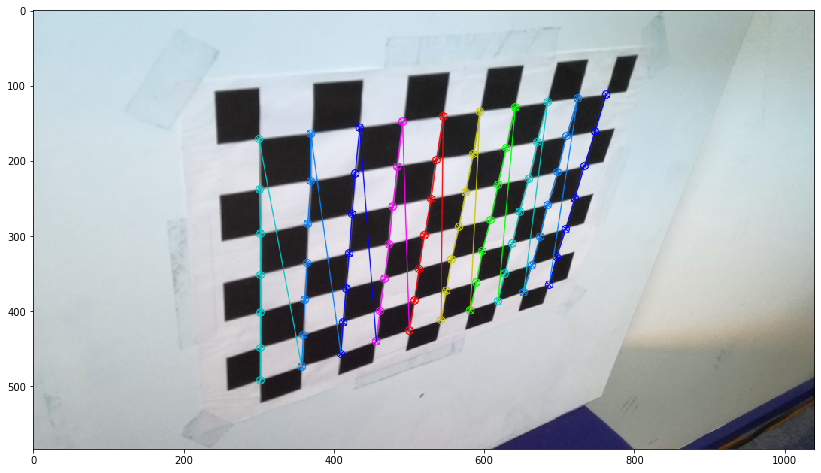

In [4]:
# Read images names
images = glob.glob(images_path + '/calibration/*.jpg')

# Define lists for storing both object points and corresponding image points
objpoints = []
imgpoints = [] 

# Find corners in each pattern
for file in images:
    img = cv2.imread(file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (corners_r,corners_c), None)
    
    # If corners are found, match object points with image corners
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # show the first image with corners detected
        cv2.drawChessboardCorners(img, (corners_r,corners_c), corners, ret)
        plt.imshow(img)

Now, we will use both lists obtained in above exercise for [cv2.calibrateCamera](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d), that returns the intrinsic, extrinsic and distortion parameters of the camera. This method also takes the size of the images (used only to initialize the intrinsic camera matrix).

Then, **answer the following questions:**

- what **type of radial distortion** have your camera?
- identify your **camera intrinsic parameters** in the camera matrix

In [5]:
# Apply Zang's method for calibrate the camera
_, intrinsic, distortion, rotation, translation = cv2.calibrateCamera(objpoints, imgpoints,(gray.shape[1],gray.shape[0]), None, None)

print(distortion)

[[ 2.26982959e-01 -9.66295385e-01 -7.04278992e-04 -7.42456854e-04
   8.82340581e-01]]


Now that we have the camera matrix and the distortion parameters, we are going to use [cv2.undistort](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga69f2545a8b62a6b0fc2ee060dc30559d). It takes the image, the camera matrix and the distortion parameters and input. Then, **removes the tangential and radial distortion** of the image and returns it.

Finally, you should **display both the original and undistorted image**. *Note that if the distortion is low, it may be unnoticeable.*

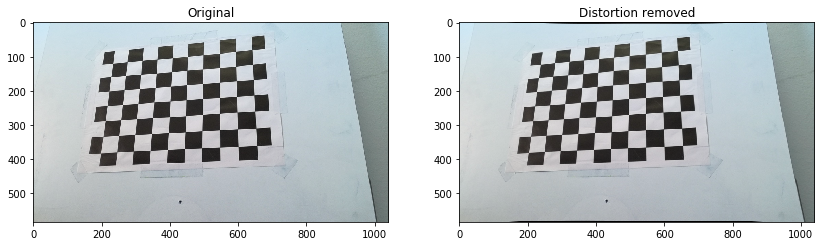

In [6]:
# Read image
img = cv2.imread(images[0])

# Undistort image
dst = cv2.undistort(img, intrinsic, distortion, None)

# Show original and undistorted
plt.subplot(121)
plt.title("Original")
plt.imshow(img)
plt.subplot(122)
plt.title("Distortion removed")
plt.imshow(dst)

## Conclusion

Great work! You better save the intrinsic values of your camera because you will need them for next chapter.

In this notebook, you have learn to:

- Calibrate any camera, using Zhang's method
- How DLT calibration method works
- Different type of distortions and how to remove them